# 04 - Evaluate Trained Classifiers on Full and Cropped Images

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, training, data, metrics, loss_functions
from src.utils import nb_setup, visualization as viz

BBOX_DATA_DIR = '03_informed_augmentation/data_snake/'
DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

MODEL_ARCH = 'efficientnet_b0'
MODEL_NAME_FULL = 'baselines_mini/clef2021_efficientnet_b0_ce_11-10-2021_11-09-53'  # trained on full images
MODEL_NAME_CROP = 'image_cropping_mini/clef2021_efficientnet_b0_ce_11-25-2021_19-15-29'  # trained on crop images
MODEL_NAME_MIX = 'image_cropping_mini/clef2021_efficientnet_b0_ce_11-25-2021_21-43-54'  # trained on full and crop images

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load the Data

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini.csv')
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

classes = np.unique(train_df['binomial'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['binomial']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 770
Train set length: 70,440
Validation set length: 26,227


In [4]:
species = np.unique(train_df['binomial'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)

country_f1_score = metrics.CountryF1Score(country_weights)

In [5]:
# include bbox annotations to the training set
bbox_df = pd.read_csv(BBOX_DATA_DIR + 'SnakeCLEF_bbox_annotations.csv')
bbox_df = bbox_df.drop_duplicates('UUID')
# assert len(bbox_df) >= len(train_df)
train_df = train_df.merge(bbox_df, 'left', on='UUID', validate='one_to_one')
valid_df = valid_df.merge(bbox_df, 'left', on='UUID', validate='one_to_one')

# create bbox column
for _df in [train_df, valid_df]:
    _df['bbox'] = _df[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda r: data.BBox(*r.values), axis=1)
    _df['bbox_area'] = _df['bbox'].apply(lambda bbox: bbox.area)

In [6]:
model_config = models.get_model(MODEL_ARCH, pretrained=False).pretrained_config
batch_size = 128

# create transforms
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

## Create Predictions on Full and Cropped Images

In [7]:
def predict_cached(model, validloader, *,
                   path, pred_filename, targ_filename, force=False):
    import os

    cached_files = os.listdir(path)
    if not force and pred_filename in cached_files and targ_filename in cached_files:
        pred = np.load(path + pred_filename)
        targ = np.load(path + targ_filename)
    else:
        pred, targ, _ = training.predict(model, validloader)
        np.save(path + pred_filename, pred)
        np.save(path + targ_filename, targ)
    return pred, targ


# create model fine-tuned on full images
model_full = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_full, MODEL_NAME_FULL, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_full.parameters()])

# create model fine-tuned on cropped images
model_crop = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_crop, MODEL_NAME_CROP, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_crop.parameters()])

# create model fine-tuned on mix images
model_mix = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_mix, MODEL_NAME_MIX, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_mix.parameters()])

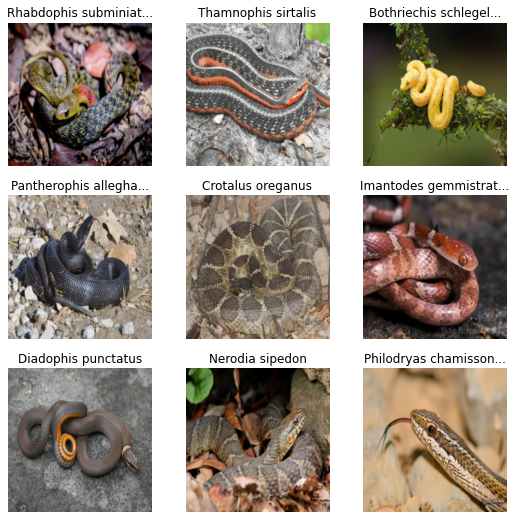

In [8]:
# create data loaders
validloader_full = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader_full.dataset.show_items()

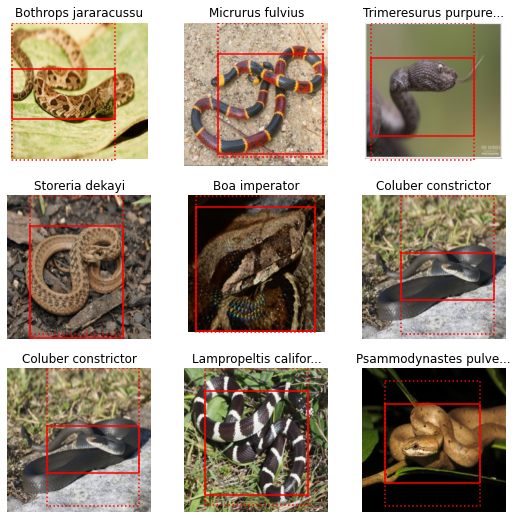

In [9]:
# create data loaders
validloader_crop = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    bbox_col='bbox',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader_crop.dataset.show_items()

### Trained on Full | Predicted on Full

In [10]:
pred_val_full_full, targ_val_full_full = predict_cached(
    model_full, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_full_full.npy', targ_filename='targ_val_full_full.npy')

scores = training.classification_scores(pred_val_full_full, targ_val_full_full)
scores['country_f1_score'] = country_f1_score(pred_val_full_full.argmax(1), targ_val_full_full)
scores

{'accuracy': 0.6908148091661265,
 'top_3': 0.8073359515003622,
 'f1_score': 0.5750808006072918,
 'country_f1_score': 0.5441918448602863}

### Trained on Full | Predicted on Cropped

In [11]:
pred_val_full_crop, targ_val_full_crop = predict_cached(
    model_full, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_full_crop.npy', targ_filename='targ_val_full_crop.npy')

scores = training.classification_scores(pred_val_full_crop, targ_val_full_crop)
scores['country_f1_score'] = country_f1_score(pred_val_full_crop.argmax(1), targ_val_full_crop)
scores

{'accuracy': 0.7098410035459641,
 'top_3': 0.8505738361230792,
 'f1_score': 0.5391226671641873,
 'country_f1_score': 0.5371445317988367}

### Trained on Cropped | Predicted on Full

In [12]:
pred_val_crop_full, targ_val_crop_full = predict_cached(
    model_crop, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_crop_full.npy', targ_filename='targ_val_crop_full.npy')

scores = training.classification_scores(pred_val_crop_full, targ_val_crop_full)
scores['country_f1_score'] = country_f1_score(pred_val_crop_full.argmax(1), targ_val_crop_full)
scores

{'accuracy': 0.6127273420520837,
 'top_3': 0.8782933618027224,
 'f1_score': 0.536892713573256,
 'country_f1_score': 0.5178959818014363}

### Trained on Cropped | Predicted on Cropped

In [13]:
pred_val_crop_crop, targ_val_crop_crop = predict_cached(
    model_crop, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_crop_crop.npy', targ_filename='targ_val_crop_crop.npy')

scores = training.classification_scores(pred_val_crop_crop, targ_val_crop_crop)
scores['country_f1_score'] = country_f1_score(pred_val_crop_crop.argmax(1), targ_val_crop_crop)
scores

{'accuracy': 0.6889465055095894,
 'top_3': 0.8180119723948602,
 'f1_score': 0.6008020811239718,
 'country_f1_score': 0.6189192019684179}

### Trained on Full and Cropped | Predicted on Full

In [14]:
pred_val_mix_full, targ_val_mix_full = predict_cached(
    model_mix, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_mix_full.npy', targ_filename='targ_val_mix_full.npy')

scores = training.classification_scores(pred_val_mix_full, targ_val_mix_full)
scores['country_f1_score'] = country_f1_score(pred_val_mix_full.argmax(1), targ_val_mix_full)
scores

{'accuracy': 0.5872955351355473,
 'top_3': 0.8151523239409768,
 'f1_score': 0.5732746195732844,
 'country_f1_score': 0.46251898584332046}

### Trained on Full and Cropped | Predicted on Cropped

In [15]:
pred_val_mix_crop, targ_val_mix_crop = predict_cached(
    model_mix, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_mix_crop.npy', targ_filename='targ_val_mix_crop.npy')

scores = training.classification_scores(pred_val_mix_crop, targ_val_mix_crop)
scores['country_f1_score'] = country_f1_score(pred_val_mix_crop.argmax(1), targ_val_mix_crop)
scores

{'accuracy': 0.6156632477980707,
 'top_3': 0.830975712052465,
 'f1_score': 0.5800187464000011,
 'country_f1_score': 0.46109785332125214}

## Evaluate Predictions of Cropped Images

In [21]:
from tqdm import tqdm

# create evaluation dataframe
eval_df = valid_df[['binomial', 'continent', 'country', 'bbox', 'bbox_area']].copy()
eval_df['bbox_area_bin'] = np.round(eval_df['bbox_area'], 1)
eval_df['targ'] = targ_val_crop_crop
eval_df['pred'] = pred_val_crop_crop.argmax(1)

/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


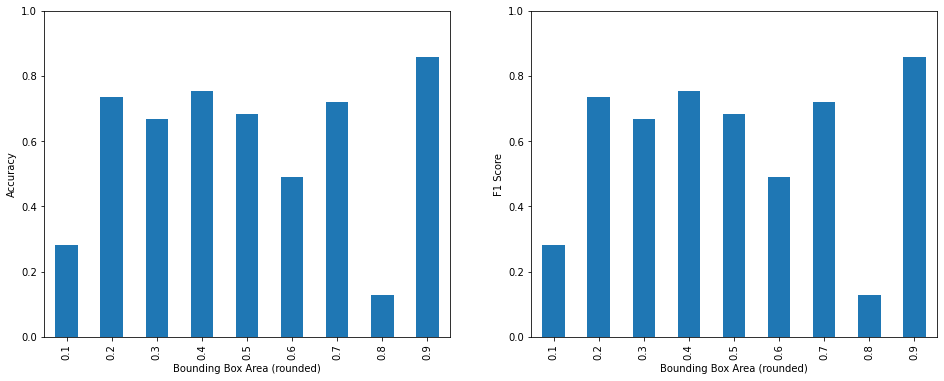

In [22]:
from sklearn.metrics import accuracy_score, f1_score

fig, (ax1, ax2) = viz.create_fig(ncols=2)

acc = eval_df.groupby('bbox_area_bin').apply(lambda g: accuracy_score(g['targ'], g['pred']))
acc.plot(kind='bar', ylim=[0, 1], ax=ax1)
ax1.set(ylabel='Accuracy', xlabel='Bounding Box Area (rounded)')

f1 = eval_df.groupby('bbox_area_bin').apply(lambda g: f1_score(g['targ'], g['pred'], average='macro'))
acc.plot(kind='bar', ylim=[0, 1], ax=ax2)
ax2.set(ylabel='F1 Score', xlabel='Bounding Box Area (rounded)')
plt.show()

## Compare Predictions of Full and Cropped Images

In [23]:
def softmax(x, axis=-1):
    e = np.exp(x - x.max())  # X.max() makes function exp more stable
    return e / e.sum(axis=axis, keepdims=True)


pred_val_full_full = softmax(pred_val_full_full)
pred_val_crop_crop = softmax(pred_val_crop_crop)

assert np.all(targ_val_full_full == targ_val_crop_crop)
targ = targ_val_full_full

# create evaluation dataframe
eval_df = pd.DataFrame()
eval_df['BBox Area'] = valid_df['bbox_area']
eval_df['Target'] = targ
eval_df['Predicted (original)'] = pred_val_full_full.argmax(1)
eval_df['Prob (original)'] = pred_val_full_full.max(1)
eval_df['Predicted (cropped)'] = pred_val_crop_crop.argmax(1)
eval_df['Prob (cropped)'] = pred_val_crop_crop.max(1)

eval_df

,BBox Area,Target,Predicted (original),Prob (original),Predicted (cropped),Prob (cropped)
0,0.219627,336,336,0.002111,339,0.002481
1,0.362245,82,82,0.003518,82,0.003522
2,0.471381,633,633,0.003512,633,0.003519
3,0.167411,507,507,0.003308,507,0.003510
4,0.322186,635,635,0.002339,635,0.002992
...,...,...,...,...,...,...
26222,0.683993,764,764,0.002153,337,0.002625
26223,0.284997,764,764,0.001822,764,0.003397
26224,0.315688,764,764,0.003485,764,0.003451
26225,0.340063,764,764,0.003235,764,0.002780


### Prediction Statistics

In [24]:
acc_full = np.sum(eval_df['Target'] == eval_df['Predicted (original)']) / len(eval_df)
acc_crop = np.sum(eval_df['Target'] == eval_df['Predicted (cropped)']) / len(eval_df)

pd.Series({
    'Accuracy (original)': acc_full,
    'Accuracy (cropped)': acc_crop})

Accuracy (original)    0.690815
Accuracy (cropped)     0.688947
dtype: float64

In [25]:
improved_acc = np.sum((eval_df['Target'] != eval_df['Predicted (original)']) &
                      (eval_df['Target'] == eval_df['Predicted (cropped)'])) / len(eval_df)
worse_acc = np.sum((eval_df['Target'] == eval_df['Predicted (original)']) &
                   (eval_df['Target'] != eval_df['Predicted (cropped)'])) / len(eval_df)

assert np.allclose(acc_full + improved_acc - worse_acc, acc_crop)
pd.Series({
    'Fraction of improved cases by cropping': improved_acc,
    'Fraction of worsened cases by cropping': worse_acc,
    'Difference': improved_acc - worse_acc})

Fraction of improved cases by cropping    0.102147
Fraction of worsened cases by cropping    0.104015
Difference                               -0.001868
dtype: float64

In [26]:
results_equal = np.sum(eval_df['Predicted (original)'] == eval_df['Predicted (cropped)']) / len(eval_df)
both_correct = np.sum((eval_df['Target'] == eval_df['Predicted (original)']) &
                      (eval_df['Target'] == eval_df['Predicted (cropped)'])) / len(eval_df)
both_wrong = np.sum((eval_df['Target'] != eval_df['Predicted (original)']) &
                    (eval_df['Target'] != eval_df['Predicted (cropped)'])) / len(eval_df)

pd.Series({
    'Original and Cropped are same': results_equal,
    'Both Original and Cropped are correct': both_correct,
    'Both Original and Cropped are wrong': both_wrong,
    'Original or Cropped is correct': 1 - both_wrong})

Original and Cropped are same            0.671179
Both Original and Cropped are correct    0.586800
Both Original and Cropped are wrong      0.207039
Original or Cropped is correct           0.792961
dtype: float64

In [27]:
# combine predictions based on the best probability
combined_pred = eval_df['Predicted (original)'].copy()
cond = eval_df['Prob (cropped)'] > eval_df['Prob (original)']
combined_pred[cond] = eval_df.loc[cond, 'Predicted (cropped)']
acc_comb = np.sum(eval_df['Target'] == combined_pred) / len(eval_df)

combined_pred_2 = np.argmax((pred_val_crop_crop + pred_val_full_full) / 2, 1)
acc_comb_2 = np.sum(eval_df['Target'] == combined_pred_2) / len(eval_df)

pd.Series({
    'Accuracy (original)': acc_full,
    'Accuracy (cropped)': acc_crop,
    'Accuracy (combined)': acc_comb,
    'Accuracy (combined - averaging probs)': acc_comb_2})

Accuracy (original)                      0.690815
Accuracy (cropped)                       0.688947
Accuracy (combined)                      0.726427
Accuracy (combined - averaging probs)    0.727075
dtype: float64

/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


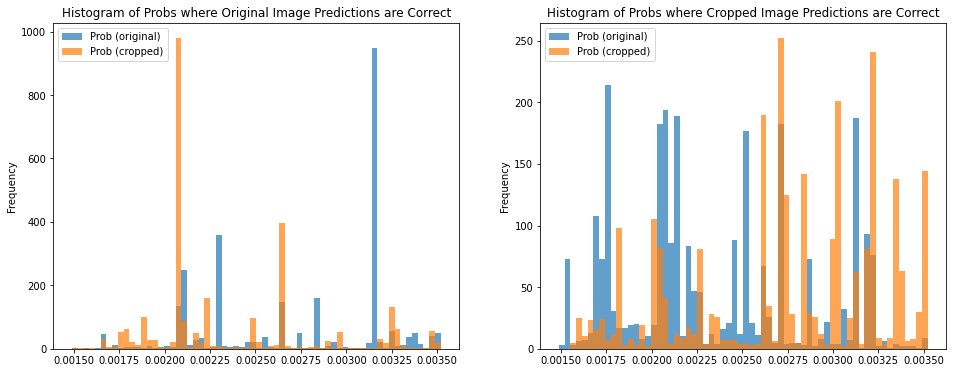

In [28]:
fig, (ax1, ax2) = viz.create_fig(ncols=2)

cond = ((eval_df['Target'] == eval_df['Predicted (original)']) &
        (eval_df['Target'] != eval_df['Predicted (cropped)']))
eval_df.loc[cond, ['Prob (original)', 'Prob (cropped)']].plot(kind='hist', bins=64, alpha=.7, ax=ax1)
ax1.set(title='Histogram of Probs where Original Image Predictions are Correct')

cond = ((eval_df['Target'] != eval_df['Predicted (original)']) &
        (eval_df['Target'] == eval_df['Predicted (cropped)']))
eval_df.loc[cond, ['Prob (original)', 'Prob (cropped)']].plot(kind='hist', bins=64, alpha=.7, ax=ax2)
ax2.set(title='Histogram of Probs where Cropped Image Predictions are Correct')
plt.show()

# todo = separate Prob (cropped) in cases where it is correct or incorrect
#      - try in 2d

### Probabilities of Targets where Predictions are Wrong

In [29]:
eval_df2 = eval_df.copy()
eval_df2['Target Prob (original)'] = pred_val_full_full[np.arange(len(targ)), targ]
eval_df2['Target Prob (cropped)'] = pred_val_crop_crop[np.arange(len(targ)), targ]

cond = ((eval_df2['Target'] != eval_df2['Predicted (original)']) &
        (eval_df2['Target'] != eval_df2['Predicted (cropped)']))
eval_df2[cond]

,BBox Area,Target,Predicted (original),Prob (original),Predicted (cropped),Prob (cropped),Target Prob (original),Target Prob (cropped)
7,0.635324,442,435,0.002473,435,0.002141,0.001458,0.001522
18,0.509766,17,20,0.003260,20,0.002684,0.001319,0.001340
22,0.185188,357,436,0.002637,436,0.001894,0.001298,0.001297
23,0.509766,17,20,0.003260,20,0.002684,0.001319,0.001340
27,0.552456,438,444,0.002478,357,0.002782,0.001302,0.001351
...,...,...,...,...,...,...,...,...
26215,0.554528,756,754,0.003449,754,0.002839,0.001299,0.001492
26216,0.445930,756,754,0.001841,667,0.001900,0.001297,0.001297
26219,0.330496,764,377,0.002567,525,0.001834,0.001298,0.001322
26220,0.231724,764,517,0.003511,517,0.003521,0.001296,0.001296


In [30]:
eval_df2.loc[cond, ['Target Prob (original)', 'Target Prob (cropped)']].median(0)

Target Prob (original)    0.001306
Target Prob (cropped)     0.001340
dtype: float32